# Per-Layer Energy Profiling for DistilBERT
## ESE 5390 Final Project: Layer-wise Energy Analysis

This notebook analyzes the energy consumption of each layer in DistilBERT (FP32 baseline).

**Goal**: Identify which layers consume the most energy to guide selective quantization strategies.

**Approach**:
1. Use PyTorch hooks to measure execution time per layer
2. Monitor GPU power during inference
3. Compute energy consumption per layer
4. Visualize energy hotspots in the model

## 1. Setup and Imports

In [1]:
import torch
import torch.nn as nn
from transformers import AutoModelForSequenceClassification
import numpy as np
import pandas as pd
import json
import time
import subprocess
import threading
from pathlib import Path
from typing import Dict, List, Tuple
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette("husl")

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")

PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA device: Tesla T4
CUDA version: 12.4


## 2. Load Dataset

In [2]:
# Auto-detect dataset path
import os

cwd = os.getcwd()
print(f"Current working directory: {cwd}")

# Check if we need to clone the repo (for Kaggle)
repo_path = Path(cwd) / "energy_aware_quantization"
if not repo_path.exists() and "kaggle" in cwd.lower():
    print("\n⚙️  Cloning repository (Kaggle environment detected)...")
    import subprocess
    result = subprocess.run(
        ["git", "clone", "https://github.com/krishkc5/energy_aware_quantization.git"],
        cwd=cwd,
        capture_output=True,
        text=True
    )
    if result.returncode == 0:
        print("✓ Repository cloned successfully")
    else:
        print(f"Warning: Could not clone repository: {result.stderr}")

possible_paths = [
    Path(cwd) / "energy_aware_quantization" / "datasets" / "sst2_tokenized_data",  # Kaggle after clone
    Path(cwd) / ".." / "datasets" / "sst2_tokenized_data",  # From notebooks/
    Path(cwd) / "datasets" / "sst2_tokenized_data",          # From repo root
    Path(cwd) / ".." / ".." / "datasets" / "sst2_tokenized_data",  # From deeper nesting
]

dataset_path = None
for path in possible_paths:
    abs_path = path.resolve()
    print(f"Trying: {abs_path}")
    if abs_path.exists() and (abs_path / "input_ids.pt").exists():
        dataset_path = str(abs_path)
        break

if dataset_path is None:
    current = Path(cwd)
    for _ in range(5):
        test_path = current / "datasets" / "sst2_tokenized_data"
        print(f"Trying: {test_path.resolve()}")
        if test_path.exists() and (test_path / "input_ids.pt").exists():
            dataset_path = str(test_path.resolve())
            break
        current = current.parent

if dataset_path is None:
    raise FileNotFoundError(
        f"Could not find dataset. Tried:\n" + 
        "\n".join([f"  - {p.resolve()}" for p in possible_paths]) +
        f"\n\nCurrent directory: {cwd}\n" +
        "Please ensure the dataset exists or the repository is cloned."
    )

print(f"\n✓ Found dataset at: {dataset_path}")

# Load dataset
device = "cuda" if torch.cuda.is_available() else "cpu"
dataset_path = Path(dataset_path)

input_ids = torch.load(dataset_path / "input_ids.pt", map_location=device)
attention_mask = torch.load(dataset_path / "attention_mask.pt", map_location=device)
labels = torch.load(dataset_path / "labels.pt", map_location=device)

print(f"\n✓ Loaded dataset:")
print(f"  - Samples: {input_ids.shape[0]}")
print(f"  - Sequence length: {input_ids.shape[1]}")
print(f"  - Device: {input_ids.device}")

Current working directory: /kaggle/working

⚙️  Cloning repository (Kaggle environment detected)...
✓ Repository cloned successfully
Trying: /kaggle/working/energy_aware_quantization/datasets/sst2_tokenized_data

✓ Found dataset at: /kaggle/working/energy_aware_quantization/datasets/sst2_tokenized_data

✓ Loaded dataset:
  - Samples: 872
  - Sequence length: 128
  - Device: cuda:0


## 3. Load DistilBERT Model

In [3]:
model_name = "distilbert-base-uncased-finetuned-sst-2-english"

print(f"Loading {model_name}...")
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    torch_dtype=torch.float32
)
model = model.to(device)
model.eval()

print(f"\n✓ Model loaded")
print(f"  - Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"  - Device: {next(model.parameters()).device}")

# Print model architecture
print(f"\n📋 Model Architecture:")
for name, module in model.named_children():
    print(f"  - {name}: {module.__class__.__name__}")

Loading distilbert-base-uncased-finetuned-sst-2-english...


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

2025-12-04 02:59:53.205515: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764817193.596879      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764817193.717900      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]


✓ Model loaded
  - Parameters: 66,955,010
  - Device: cuda:0

📋 Model Architecture:
  - distilbert: DistilBertModel
  - pre_classifier: Linear
  - classifier: Linear
  - dropout: Dropout


## 4. Layer Profiler with Timing Hooks

We'll use PyTorch forward hooks to measure execution time for each layer.

In [4]:
class LayerProfiler:
    """
    Profile execution time of each layer using forward hooks.
    """
    
    def __init__(self, model: nn.Module, device: str = "cuda"):
        self.model = model
        self.device = device
        self.hooks = []
        self.layer_times = defaultdict(list)
        self.layer_names = []
        self.current_forward_start = None
        
        # Register hooks for all named modules
        self._register_hooks()
    
    def _register_hooks(self):
        """Register forward pre/post hooks on all layers."""
        
        def make_pre_hook(name):
            def pre_hook(module, input):
                if self.device == "cuda":
                    torch.cuda.synchronize()
                self.layer_times[name + "_start"].append(time.perf_counter())
            return pre_hook
        
        def make_post_hook(name):
            def post_hook(module, input, output):
                if self.device == "cuda":
                    torch.cuda.synchronize()
                self.layer_times[name + "_end"].append(time.perf_counter())
            return post_hook
        
        # Register hooks on important layers
        for name, module in self.model.named_modules():
            # Skip container modules and focus on actual computation layers
            if len(list(module.children())) == 0:  # Leaf modules only
                if isinstance(module, (nn.Linear, nn.LayerNorm, nn.Dropout, nn.GELU, nn.Embedding)):
                    self.layer_names.append(name)
                    hook_pre = module.register_forward_pre_hook(make_pre_hook(name))
                    hook_post = module.register_forward_hook(make_post_hook(name))
                    self.hooks.append(hook_pre)
                    self.hooks.append(hook_post)
        
        print(f"✓ Registered hooks on {len(self.layer_names)} layers")
    
    def reset(self):
        """Reset timing statistics."""
        self.layer_times.clear()
    
    def remove_hooks(self):
        """Remove all hooks."""
        for hook in self.hooks:
            hook.remove()
        self.hooks.clear()
    
    def get_layer_times(self) -> Dict[str, float]:
        """
        Compute average execution time per layer.
        
        Returns:
            Dictionary mapping layer name to average time in seconds
        """
        layer_avg_times = {}
        
        for name in self.layer_names:
            start_times = self.layer_times.get(name + "_start", [])
            end_times = self.layer_times.get(name + "_end", [])
            
            if len(start_times) == len(end_times) and len(start_times) > 0:
                durations = [end - start for start, end in zip(start_times, end_times)]
                layer_avg_times[name] = np.mean(durations)
        
        return layer_avg_times
    
    def get_layer_stats(self) -> pd.DataFrame:
        """
        Get detailed statistics for each layer.
        
        Returns:
            DataFrame with layer statistics
        """
        stats = []
        
        for name in self.layer_names:
            start_times = self.layer_times.get(name + "_start", [])
            end_times = self.layer_times.get(name + "_end", [])
            
            if len(start_times) == len(end_times) and len(start_times) > 0:
                durations = [end - start for start, end in zip(start_times, end_times)]
                
                stats.append({
                    "layer_name": name,
                    "mean_time_ms": np.mean(durations) * 1000,
                    "std_time_ms": np.std(durations) * 1000,
                    "min_time_ms": np.min(durations) * 1000,
                    "max_time_ms": np.max(durations) * 1000,
                    "total_time_s": np.sum(durations),
                    "num_calls": len(durations)
                })
        
        df = pd.DataFrame(stats)
        
        # Add percentage of total time
        if len(df) > 0:
            total_time = df["total_time_s"].sum()
            df["percent_total"] = (df["total_time_s"] / total_time) * 100
        
        return df.sort_values("total_time_s", ascending=False)


# Create profiler
profiler = LayerProfiler(model, device=device)

✓ Registered hooks on 67 layers


## 5. Power Monitor

Simple power monitoring using nvidia-smi.

In [5]:
class SimplePowerMonitor:
    """
    Simple power monitor using nvidia-smi.
    """
    
    def __init__(self, interval_ms: int = 50, gpu_id: int = 0):
        self.interval_ms = interval_ms
        self.gpu_id = gpu_id
        self.samples = []
        self.is_running = False
        self._thread = None
        self._lock = threading.Lock()
    
    def _poll(self):
        """Poll nvidia-smi for power readings."""
        interval_sec = self.interval_ms / 1000.0
        
        while self.is_running:
            try:
                result = subprocess.run(
                    ["nvidia-smi", "--query-gpu=power.draw", "--format=csv,noheader,nounits", f"--id={self.gpu_id}"],
                    capture_output=True, text=True, timeout=2
                )
                if result.returncode == 0:
                    power = float(result.stdout.strip())
                    with self._lock:
                        self.samples.append((time.perf_counter(), power))
            except:
                pass
            time.sleep(interval_sec)
    
    def start(self):
        """Start monitoring."""
        with self._lock:
            self.samples = []
            self.is_running = True
        
        self._thread = threading.Thread(target=self._poll, daemon=True)
        self._thread.start()
    
    def stop(self):
        """Stop monitoring."""
        self.is_running = False
        if self._thread:
            self._thread.join(timeout=2)
    
    def get_samples(self) -> List[Tuple[float, float]]:
        """Get (timestamp, power) samples."""
        with self._lock:
            return self.samples.copy()
    
    def get_mean_power(self) -> float:
        """Get mean power in Watts."""
        samples = self.get_samples()
        if len(samples) == 0:
            return 0.0
        return np.mean([p for _, p in samples])


power_monitor = SimplePowerMonitor(interval_ms=50)
print("✓ Power monitor initialized")

✓ Power monitor initialized


## 6. Run Profiling Inference

Run inference with layer profiling and power monitoring.

In [6]:
# Warmup
print("Warming up GPU...")
with torch.no_grad():
    for _ in range(50):
        _ = model(input_ids=input_ids, attention_mask=attention_mask)
if device == "cuda":
    torch.cuda.synchronize()
print("✓ Warmup complete\n")

# Reset profiler
profiler.reset()

# Run profiling with power monitoring
num_iters = 100
print(f"Running {num_iters} profiling iterations...")

power_monitor.start()
time.sleep(0.3)  # Let power monitor stabilize

if device == "cuda":
    torch.cuda.synchronize()

start_time = time.perf_counter()

with torch.no_grad():
    for i in range(num_iters):
        _ = model(input_ids=input_ids, attention_mask=attention_mask)
        
        if (i + 1) % 20 == 0:
            print(f"  Progress: {i+1}/{num_iters}", end='\r')

if device == "cuda":
    torch.cuda.synchronize()

end_time = time.perf_counter()

time.sleep(0.3)  # Capture trailing power samples
power_monitor.stop()

total_time = end_time - start_time
mean_power = power_monitor.get_mean_power()

print(f"\n\n✓ Profiling complete")
print(f"  - Total time: {total_time:.3f}s")
print(f"  - Mean power: {mean_power:.2f}W")
print(f"  - Total energy: {mean_power * total_time:.3f}J")
print(f"  - Power samples: {len(power_monitor.get_samples())}")

Warming up GPU...
✓ Warmup complete

Running 100 profiling iterations...
  Progress: 100/100

✓ Profiling complete
  - Total time: 305.644s
  - Mean power: 67.08W
  - Total energy: 20502.217J
  - Power samples: 4170


## 7. Analyze Per-Layer Timing

In [7]:
# Get layer statistics
layer_stats = profiler.get_layer_stats()

print("\n" + "="*80)
print("PER-LAYER TIMING STATISTICS (Top 20)")
print("="*80)
print(layer_stats.head(20).to_string(index=False))
print("="*80)

# Save to CSV
output_dir = Path("../results")
output_dir.mkdir(parents=True, exist_ok=True)
layer_stats.to_csv(output_dir / "per_layer_timing_fp32.csv", index=False)
print(f"\n✓ Saved layer timing to: {output_dir / 'per_layer_timing_fp32.csv'}")


PER-LAYER TIMING STATISTICS (Top 20)
                                    layer_name  mean_time_ms  std_time_ms  min_time_ms  max_time_ms  total_time_s  num_calls  percent_total
       distilbert.transformer.layer.1.ffn.lin1    172.837556     1.405657   168.379358   176.092329     17.283756        100       6.228583
       distilbert.transformer.layer.2.ffn.lin1    172.633812     1.344741   168.762648   176.776104     17.263381        100       6.221241
       distilbert.transformer.layer.3.ffn.lin1    172.513837     1.362991   169.535433   176.583443     17.251384        100       6.216917
       distilbert.transformer.layer.4.ffn.lin1    171.923638     1.326182   168.364197   175.849198     17.192364        100       6.195648
       distilbert.transformer.layer.0.ffn.lin1    171.751783     1.445369   167.821313   175.780768     17.175178        100       6.189455
       distilbert.transformer.layer.5.ffn.lin1    171.090665     1.479921   167.032819   174.641358     17.109066        1

## 8. Compute Per-Layer Energy Consumption

Estimate energy per layer using:
- Layer execution time (from profiling)
- Mean GPU power (from power monitor)

**Energy per layer = (Layer time / Total time) × Total energy**

In [8]:
# Compute per-layer energy
total_energy = mean_power * total_time  # Joules
total_measured_time = layer_stats["total_time_s"].sum()

layer_stats["energy_j"] = (layer_stats["total_time_s"] / total_measured_time) * total_energy
layer_stats["energy_mj"] = layer_stats["energy_j"] * 1000
layer_stats["energy_per_call_mj"] = layer_stats["energy_mj"] / layer_stats["num_calls"]

# Sort by energy consumption
layer_stats = layer_stats.sort_values("energy_j", ascending=False)

print("\n" + "="*100)
print("PER-LAYER ENERGY CONSUMPTION (Top 20)")
print("="*100)
print(layer_stats[["layer_name", "mean_time_ms", "energy_mj", "energy_per_call_mj", "percent_total"]].head(20).to_string(index=False))
print("="*100)

# Save to CSV
layer_stats.to_csv(output_dir / "per_layer_energy_fp32.csv", index=False)
print(f"\n✓ Saved layer energy to: {output_dir / 'per_layer_energy_fp32.csv'}")


PER-LAYER ENERGY CONSUMPTION (Top 20)
                                    layer_name  mean_time_ms    energy_mj  energy_per_call_mj  percent_total
       distilbert.transformer.layer.1.ffn.lin1    172.837556 1.276998e+06        12769.976577       6.228583
       distilbert.transformer.layer.2.ffn.lin1    172.633812 1.275492e+06        12754.923156       6.221241
       distilbert.transformer.layer.3.ffn.lin1    172.513837 1.274606e+06        12746.058905       6.216917
       distilbert.transformer.layer.4.ffn.lin1    171.923638 1.270245e+06        12702.452467       6.195648
       distilbert.transformer.layer.0.ffn.lin1    171.751783 1.268976e+06        12689.755100       6.189455
       distilbert.transformer.layer.5.ffn.lin1    171.090665 1.264091e+06        12640.908827       6.165630
       distilbert.transformer.layer.1.ffn.lin2    142.967415 1.056304e+06        10563.043077       5.152147
       distilbert.transformer.layer.2.ffn.lin2    142.938832 1.056093e+06        10560.93

## 9. Group Energy by Layer Type

In [9]:
# Extract layer type from name
def get_layer_type(name: str) -> str:
    """Extract layer type from full layer name."""
    if "attention.q_lin" in name or "attention.k_lin" in name or "attention.v_lin" in name:
        return "Attention Projection"
    elif "attention.out_lin" in name:
        return "Attention Output"
    elif "ffn.lin1" in name:
        return "FFN Layer 1"
    elif "ffn.lin2" in name:
        return "FFN Layer 2"
    elif "sa_layer_norm" in name or "output_layer_norm" in name:
        return "LayerNorm"
    elif "embeddings" in name:
        return "Embeddings"
    elif "pre_classifier" in name or "classifier" in name:
        return "Classifier"
    elif "dropout" in name:
        return "Dropout"
    else:
        return "Other"

layer_stats["layer_type"] = layer_stats["layer_name"].apply(get_layer_type)

# Group by layer type
type_energy = layer_stats.groupby("layer_type").agg({
    "energy_j": "sum",
    "energy_mj": "sum",
    "total_time_s": "sum",
    "layer_name": "count"
}).rename(columns={"layer_name": "num_layers"})

type_energy["percent_energy"] = (type_energy["energy_j"] / type_energy["energy_j"].sum()) * 100
type_energy = type_energy.sort_values("energy_j", ascending=False)

print("\n" + "="*80)
print("ENERGY CONSUMPTION BY LAYER TYPE")
print("="*80)
print(type_energy.to_string())
print("="*80)

# Save to CSV
type_energy.to_csv(output_dir / "energy_by_layer_type_fp32.csv")
print(f"\n✓ Saved grouped energy to: {output_dir / 'energy_by_layer_type_fp32.csv'}")


ENERGY CONSUMPTION BY LAYER TYPE
                         energy_j     energy_mj  total_time_s  num_layers  percent_energy
layer_type                                                                               
FFN Layer 1           7630.407503  7.630408e+06    103.275129           6       37.217475
FFN Layer 2           6311.489920  6.311490e+06     85.424001           6       30.784427
Attention Projection  4722.460730  4.722461e+06     63.916998          18       23.033903
Attention Output      1475.250210  1.475250e+06     19.967041           6        7.195564
LayerNorm              301.511577  3.015116e+05      4.080863          12        1.470629
Embeddings              54.679718  5.467972e+04      0.740073           4        0.266701
Classifier               4.296795  4.296795e+03      0.058156           2        0.020958
Dropout                  2.120417  2.120417e+03      0.028699           7        0.010342

✓ Saved grouped energy to: ../results/energy_by_layer_type_fp32.c

## 10. Visualizations


✓ Saved plots to: ../results/per_layer_energy_analysis_fp32.png


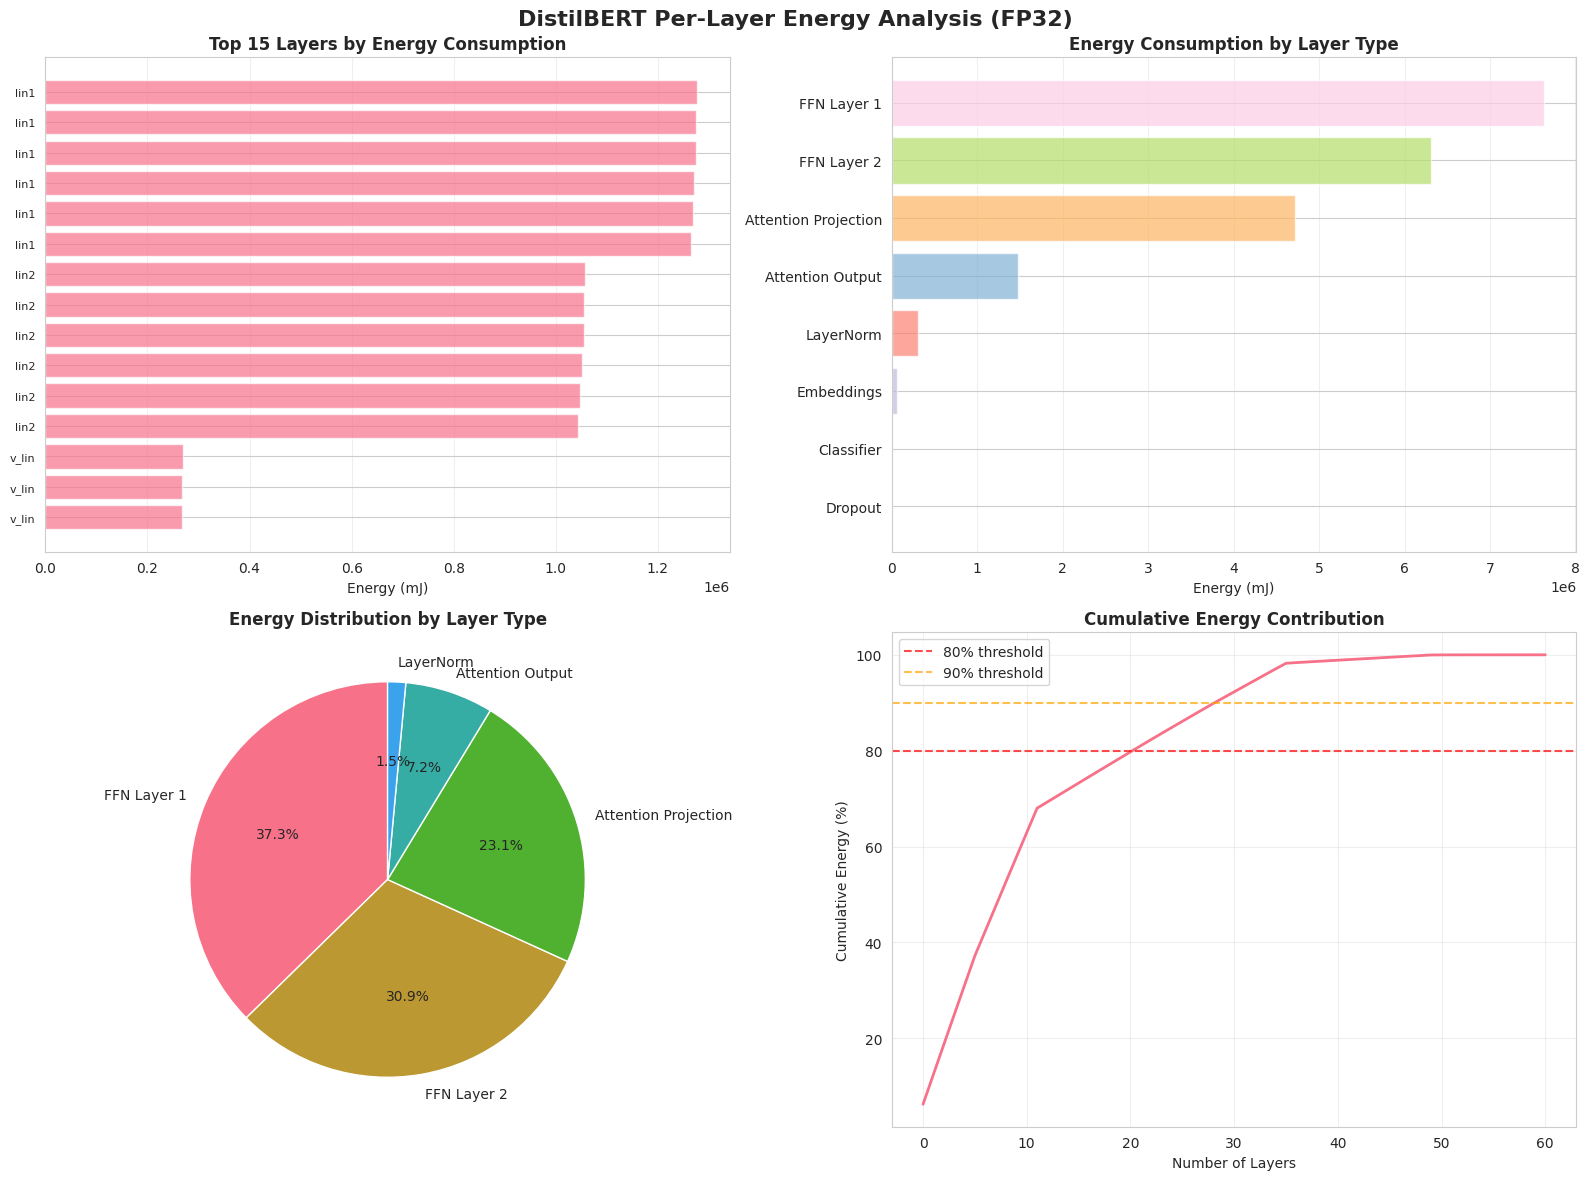

In [10]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("DistilBERT Per-Layer Energy Analysis (FP32)", fontsize=16, fontweight='bold')

# 1. Top 15 layers by energy
ax = axes[0, 0]
top_layers = layer_stats.head(15)
y_pos = range(len(top_layers))
ax.barh(y_pos, top_layers["energy_mj"], alpha=0.7)
ax.set_yticks(y_pos)
ax.set_yticklabels([name.split('.')[-1] if len(name.split('.')) > 1 else name for name in top_layers["layer_name"]], fontsize=8)
ax.set_xlabel("Energy (mJ)", fontsize=10)
ax.set_title("Top 15 Layers by Energy Consumption", fontsize=12, fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

# 2. Energy by layer type
ax = axes[0, 1]
type_energy_sorted = type_energy.sort_values("energy_mj", ascending=True)
y_pos = range(len(type_energy_sorted))
colors = plt.cm.Set3(range(len(type_energy_sorted)))
ax.barh(y_pos, type_energy_sorted["energy_mj"], alpha=0.7, color=colors)
ax.set_yticks(y_pos)
ax.set_yticklabels(type_energy_sorted.index, fontsize=10)
ax.set_xlabel("Energy (mJ)", fontsize=10)
ax.set_title("Energy Consumption by Layer Type", fontsize=12, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# 3. Pie chart of energy distribution
ax = axes[1, 0]
type_energy_pie = type_energy[type_energy["percent_energy"] > 1.0]  # Show only >1%
ax.pie(type_energy_pie["percent_energy"], labels=type_energy_pie.index, autopct='%1.1f%%', startangle=90)
ax.set_title("Energy Distribution by Layer Type", fontsize=12, fontweight='bold')

# 4. Cumulative energy contribution
ax = axes[1, 1]
cumulative = layer_stats["energy_mj"].cumsum() / layer_stats["energy_mj"].sum() * 100
ax.plot(range(len(cumulative)), cumulative, linewidth=2)
ax.axhline(y=80, color='r', linestyle='--', alpha=0.7, label='80% threshold')
ax.axhline(y=90, color='orange', linestyle='--', alpha=0.7, label='90% threshold')
ax.set_xlabel("Number of Layers", fontsize=10)
ax.set_ylabel("Cumulative Energy (%)", fontsize=10)
ax.set_title("Cumulative Energy Contribution", fontsize=12, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plot_path = output_dir / "per_layer_energy_analysis_fp32.png"
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"\n✓ Saved plots to: {plot_path}")
plt.show()

## 11. Key Insights

Identify the most energy-hungry layers for targeted quantization.

In [11]:
# Find how many layers account for 80% of energy
cumulative_energy = layer_stats["energy_j"].cumsum() / layer_stats["energy_j"].sum()
layers_for_80_pct = (cumulative_energy <= 0.80).sum()
layers_for_90_pct = (cumulative_energy <= 0.90).sum()

print("\n" + "="*80)
print("KEY INSIGHTS")
print("="*80)

print(f"\n📊 Energy Distribution:")
print(f"  - Total layers profiled: {len(layer_stats)}")
print(f"  - Layers accounting for 80% of energy: {layers_for_80_pct} ({layers_for_80_pct/len(layer_stats)*100:.1f}%)")
print(f"  - Layers accounting for 90% of energy: {layers_for_90_pct} ({layers_for_90_pct/len(layer_stats)*100:.1f}%)")

print(f"\n🔥 Top Energy Consumers:")
top_3 = layer_stats.head(3)
for i, row in top_3.iterrows():
    print(f"  {row['layer_name']}:")
    print(f"    - Energy: {row['energy_mj']:.2f} mJ ({row['percent_total']:.1f}% of total)")
    print(f"    - Avg time: {row['mean_time_ms']:.3f} ms per call")

print(f"\n🎯 Quantization Strategy Recommendations:")
print(f"  1. Prioritize quantizing: {type_energy.head(3).index.tolist()}")
print(f"  2. These layer types account for {type_energy.head(3)['percent_energy'].sum():.1f}% of total energy")
print(f"  3. Consider keeping embeddings and LayerNorm in higher precision")

print("\n" + "="*80)


KEY INSIGHTS

📊 Energy Distribution:
  - Total layers profiled: 61
  - Layers accounting for 80% of energy: 21 (34.4%)
  - Layers accounting for 90% of energy: 29 (47.5%)

🔥 Top Energy Consumers:
  distilbert.transformer.layer.1.ffn.lin1:
    - Energy: 1276997.66 mJ (6.2% of total)
    - Avg time: 172.838 ms per call
  distilbert.transformer.layer.2.ffn.lin1:
    - Energy: 1275492.32 mJ (6.2% of total)
    - Avg time: 172.634 ms per call
  distilbert.transformer.layer.3.ffn.lin1:
    - Energy: 1274605.89 mJ (6.2% of total)
    - Avg time: 172.514 ms per call

🎯 Quantization Strategy Recommendations:
  1. Prioritize quantizing: ['FFN Layer 1', 'FFN Layer 2', 'Attention Projection']
  2. These layer types account for 91.0% of total energy
  3. Consider keeping embeddings and LayerNorm in higher precision



## 12. Export Summary Report

In [12]:
# Create summary report
summary_report = {
    "model_name": model_name,
    "precision": "fp32",
    "num_profiling_iterations": num_iters,
    "total_time_s": float(total_time),
    "mean_power_w": float(mean_power),
    "total_energy_j": float(total_energy),
    "num_layers_profiled": len(layer_stats),
    "layers_for_80pct_energy": int(layers_for_80_pct),
    "layers_for_90pct_energy": int(layers_for_90_pct),
    "top_energy_layer": layer_stats.iloc[0]["layer_name"],
    "top_energy_layer_mj": float(layer_stats.iloc[0]["energy_mj"]),
    "top_energy_layer_percent": float(layer_stats.iloc[0]["percent_total"]),
    "energy_by_type": type_energy.to_dict(),
}

# Save as JSON
report_path = output_dir / "per_layer_energy_summary_fp32.json"
with open(report_path, 'w') as f:
    json.dump(summary_report, f, indent=2)

print(f"✓ Saved summary report to: {report_path}")

# Clean up
profiler.remove_hooks()
print("\n✓ Profiling complete and hooks removed")

✓ Saved summary report to: ../results/per_layer_energy_summary_fp32.json

✓ Profiling complete and hooks removed


## 13. Model Prediction Impact Analysis

Measure how much each layer contributes to model predictions using layer ablation.

**Method**: For each layer, we'll:
1. Get baseline predictions from the full model
2. Ablate the layer (zero out its output) and measure prediction change
3. Compute impact metrics (KL divergence, accuracy drop, logit change)


In [ ]:
class LayerAblationAnalyzer:
    """
    Analyze prediction impact of each layer by ablating (zeroing out) layers.
    """
    
    def __init__(self, model: nn.Module, device: str = "cuda"):
        self.model = model
        self.device = device
        self.hooks = []
        self.layer_names = []
        
        # Get all leaf modules (actual computation layers)
        for name, module in model.named_modules():
            if len(list(module.children())) == 0:  # Leaf modules only
                if isinstance(module, (nn.Linear, nn.LayerNorm, nn.Dropout, nn.GELU, nn.Embedding)):
                    self.layer_names.append(name)
        
        print(f"✓ Found {len(self.layer_names)} layers for ablation analysis")
    
    def _make_ablation_hook(self, layer_name: str):
        """Create a hook that zeros out the layer output."""
        def ablation_hook(module, input, output):
            # Zero out the output
            if isinstance(output, torch.Tensor):
                return torch.zeros_like(output)
            elif isinstance(output, tuple):
                return tuple(torch.zeros_like(o) if isinstance(o, torch.Tensor) else o for o in output)
            return output
        return ablation_hook
    
    def get_baseline_predictions(self, input_ids, attention_mask, labels=None, num_samples: int = 100):
        """Get baseline predictions from the full model."""
        self.model.eval()
        with torch.no_grad():
            # Use a subset of samples for efficiency
            sample_indices = torch.randperm(input_ids.shape[0])[:num_samples]
            sample_input_ids = input_ids[sample_indices]
            sample_attention_mask = attention_mask[sample_indices]
            sample_labels = labels[sample_indices] if labels is not None else None
            
            outputs = self.model(input_ids=sample_input_ids, attention_mask=sample_attention_mask)
            logits = outputs.logits
            
            # Compute baseline accuracy
            if sample_labels is not None:
                preds = torch.argmax(logits, dim=-1)
                baseline_accuracy = (preds == sample_labels).float().mean().item()
            else:
                baseline_accuracy = None
            
            return {
                'logits': logits,  # Keep on CUDA
                'probs': torch.softmax(logits, dim=-1),  # Keep on CUDA
                'accuracy': baseline_accuracy,
                'indices': sample_indices  # Keep on CUDA
            }
    
    def measure_layer_impact(self, input_ids, attention_mask, layer_name: str, baseline: dict, labels=None):
        """
        Measure prediction impact of ablating a specific layer.
        
        Returns:
            Dictionary with impact metrics
        """
        self.model.eval()
        
        # Register ablation hook
        module = dict(self.model.named_modules())[layer_name]
        hook = module.register_forward_hook(self._make_ablation_hook(layer_name))
        self.hooks.append(hook)
        
        try:
            with torch.no_grad():
                sample_input_ids = input_ids[baseline['indices']]
                sample_attention_mask = attention_mask[baseline['indices']]
                sample_labels = labels[baseline['indices']] if labels is not None else None
                
                outputs = self.model(input_ids=sample_input_ids, attention_mask=sample_attention_mask)
                ablated_logits = outputs.logits
                ablated_probs = torch.softmax(ablated_logits, dim=-1)
            
            # Compute impact metrics
            baseline_logits = baseline['logits']
            baseline_probs = baseline['probs']
            
            # 1. KL Divergence (higher = more impact)
            kl_div = torch.nn.functional.kl_div(
                torch.log(ablated_probs + 1e-8),
                baseline_probs,
                reduction='batchmean'
            ).item()
            
            # 2. L2 distance in logit space
            logit_l2 = torch.nn.functional.mse_loss(
                ablated_logits,
                baseline_logits
            ).item()
            
            # 3. Accuracy drop
            if sample_labels is not None:
                ablated_preds = torch.argmax(ablated_logits, dim=-1)
                ablated_accuracy = (ablated_preds == sample_labels).float().mean().item()
                accuracy_drop = baseline['accuracy'] - ablated_accuracy
            else:
                accuracy_drop = None
            
            # 4. Max logit change
            max_logit_change = torch.abs(ablated_logits - baseline_logits).max().item()
            
            # 5. Mean absolute logit change
            mean_logit_change = torch.abs(ablated_logits - baseline_logits).mean().item()
            
            return {
                'kl_divergence': kl_div,
                'logit_l2': logit_l2,
                'accuracy_drop': accuracy_drop,
                'max_logit_change': max_logit_change,
                'mean_logit_change': mean_logit_change,
                'impact_score': kl_div + logit_l2  # Combined impact score
            }
        finally:
            # Remove hook
            hook.remove()
            if hook in self.hooks:
                self.hooks.remove(hook)
    
    def analyze_all_layers(self, input_ids, attention_mask, labels=None, num_samples: int = 100):
        """
        Analyze impact of ablating each layer.
        
        Returns:
            DataFrame with impact metrics for each layer
        """
        print(f"\n📊 Computing baseline predictions ({num_samples} samples)...")
        baseline = self.get_baseline_predictions(input_ids, attention_mask, labels, num_samples)
        print(f"✓ Baseline accuracy: {baseline['accuracy']:.4f}" if baseline['accuracy'] is not None else "✓ Baseline computed")
        
        print(f"\n🔬 Analyzing {len(self.layer_names)} layers...")
        results = []
        
        for i, layer_name in enumerate(self.layer_names):
            if (i + 1) % 10 == 0:
                print(f"  Progress: {i+1}/{len(self.layer_names)}", end='\r')
            
            impact = self.measure_layer_impact(input_ids, attention_mask, layer_name, baseline, labels)
            impact['layer_name'] = layer_name
            results.append(impact)
        
        print(f"\n✓ Analysis complete")
        
        df = pd.DataFrame(results)
        df = df.sort_values('impact_score', ascending=False)
        
        return df


# Create analyzer
analyzer = LayerAblationAnalyzer(model, device=device)


## 14. Run Prediction Impact Analysis


In [ ]:
# Run ablation analysis
# Use a subset of samples for efficiency (100 samples should be sufficient)
impact_df = analyzer.analyze_all_layers(input_ids, attention_mask, labels=labels, num_samples=100)

print("\n" + "="*100)
print("PREDICTION IMPACT ANALYSIS (Top 20 Layers`)")
print("="*100)
print(impact_df.head(20).to_string(index=False))
print("="*100)

# Save to CSV
impact_df.to_csv(output_dir / "per_layer_prediction_impact_fp32.csv", index=False)
print(f"\n✓ Saved prediction impact to: {output_dir / 'per_layer_prediction_impact_fp32.csv'}")


## 15. Group Prediction Impact by Layer Type


In [ ]:
# Add layer type to impact dataframe
impact_df["layer_type"] = impact_df["layer_name"].apply(get_layer_type)

# Group by layer type
type_impact = impact_df.groupby("layer_type").agg({
    "kl_divergence": "mean",
    "logit_l2": "mean",
    "accuracy_drop": "mean",
    "max_logit_change": "mean",
    "mean_logit_change": "mean",
    "impact_score": "mean",
    "layer_name": "count"
}).rename(columns={"layer_name": "num_layers"})

type_impact = type_impact.sort_values("impact_score", ascending=False)

print("\n" + "="*100)
print("PREDICTION IMPACT BY LAYER TYPE")
print("="*100)
print(type_impact.to_string())
print("="*100)

# Save to CSV
type_impact.to_csv(output_dir / "prediction_impact_by_layer_type_fp32.csv")
print(f"\n✓ Saved grouped impact to: {output_dir / 'prediction_impact_by_layer_type_fp32.csv'}")


## 16. Visualize Prediction Impact by Layer Type

Create a bar chart similar to the energy consumption chart, showing prediction impact per layer type.


In [ ]:
# Create prediction impact visualization (similar to energy chart)
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Sort by impact score (descending)
type_impact_sorted = type_impact.sort_values("impact_score", ascending=True)

# Create horizontal bar chart
y_pos = range(len(type_impact_sorted))
colors = plt.cm.Set3(range(len(type_impact_sorted)))

bars = ax.barh(y_pos, type_impact_sorted["impact_score"], alpha=0.7, color=colors)
ax.set_yticks(y_pos)
ax.set_yticklabels(type_impact_sorted.index, fontsize=12)
ax.set_xlabel("Prediction Impact Score", fontsize=14, fontweight='bold')
ax.set_title("Model Prediction Impact by Layer Type", fontsize=16, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, (idx, row) in enumerate(type_impact_sorted.iterrows()):
    ax.text(row["impact_score"] * 0.02, i, f'{row["impact_score"]:.3f}', 
            va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plot_path = output_dir / "prediction_impact_by_layer_type_fp32.png"
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved prediction impact chart to: {plot_path}")
plt.show()


## 17. Merge Energy and Prediction Impact Data

Combine energy consumption and prediction impact data for correlation analysis.


In [ ]:
# Merge energy and impact data
# Use layer_stats (energy) and impact_df (prediction impact)
merged_df = layer_stats[["layer_name", "energy_j", "energy_mj", "layer_type"]].merge(
    impact_df[["layer_name", "kl_divergence", "logit_l2", "accuracy_drop", "impact_score"]],
    on="layer_name",
    how="inner"
)

print(f"\n✓ Merged data: {len(merged_df)} layers")
print(f"\nFirst few rows:")
print(merged_df.head(10).to_string(index=False))

# Save merged data
merged_df.to_csv(output_dir / "energy_and_impact_merged_fp32.csv", index=False)
print(f"\n✓ Saved merged data to: {output_dir / 'energy_and_impact_merged_fp32.csv'}")


## 18. Correlation Analysis: Energy vs Prediction Impact

Create a correlation matrix showing the relationship between energy consumption and prediction impact for all 67 layers.


In [ ]:
# Prepare data for correlation matrix
# Normalize energy and impact scores for better visualization
merged_df["energy_normalized"] = (merged_df["energy_mj"] - merged_df["energy_mj"].min()) / (merged_df["energy_mj"].max() - merged_df["energy_mj"].min())
merged_df["impact_normalized"] = (merged_df["impact_score"] - merged_df["impact_score"].min()) / (merged_df["impact_score"].max() - merged_df["impact_score"].min())

# Select columns for correlation
corr_columns = [
    "energy_j", "energy_mj", 
    "kl_divergence", "logit_l2", "accuracy_drop", "impact_score",
    "energy_normalized", "impact_normalized"
]

# Compute correlation matrix
corr_matrix = merged_df[corr_columns].corr()

print("\n" + "="*100)
print("CORRELATION MATRIX: Energy Consumption vs Prediction Impact")
print("="*100)
print(corr_matrix.to_string())
print("="*100)

# Key correlations
print(f"\n📊 Key Correlations:")
print(f"  Energy (mJ) vs Impact Score: {corr_matrix.loc['energy_mj', 'impact_score']:.4f}")
print(f"  Energy (mJ) vs KL Divergence: {corr_matrix.loc['energy_mj', 'kl_divergence']:.4f}")
print(f"  Energy (mJ) vs Logit L2: {corr_matrix.loc['energy_mj', 'logit_l2']:.4f}")
if not pd.isna(corr_matrix.loc['energy_mj', 'accuracy_drop']):
    print(f"  Energy (mJ) vs Accuracy Drop: {corr_matrix.loc['energy_mj', 'accuracy_drop']:.4f}")

# Save correlation matrix
corr_matrix.to_csv(output_dir / "energy_impact_correlation_matrix_fp32.csv")
print(f"\n✓ Saved correlation matrix to: {output_dir / 'energy_impact_correlation_matrix_fp32.csv'}")


## 19. Visualize Correlation Matrix

Create a heatmap visualization of the correlation matrix.


In [ ]:
# Create correlation heatmap
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Create heatmap
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)  # Mask upper triangle
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.3f',
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    mask=mask,
    ax=ax
)

ax.set_title("Correlation Matrix: Energy Consumption vs Prediction Impact\n(All 67 Layers)", 
             fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plot_path = output_dir / "energy_impact_correlation_heatmap_fp32.png"
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved correlation heatmap to: {plot_path}")
plt.show()


## 20. Scatter Plot: Energy vs Prediction Impact

Visualize the relationship between energy consumption and prediction impact for individual layers.


In [ ]:
# Create scatter plot: Energy vs Impact
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Color by layer type
layer_types = merged_df["layer_type"].unique()
colors_map = dict(zip(layer_types, plt.cm.Set3(range(len(layer_types)))))

for layer_type in layer_types:
    mask = merged_df["layer_type"] == layer_type
    ax.scatter(
        merged_df.loc[mask, "energy_mj"],
        merged_df.loc[mask, "impact_score"],
        label=layer_type,
        alpha=0.6,
        s=100,
        color=colors_map[layer_type]
    )

ax.set_xlabel("Energy Consumption (mJ)", fontsize=14, fontweight='bold')
ax.set_ylabel("Prediction Impact Score", fontsize=14, fontweight='bold')
ax.set_title("Energy Consumption vs Prediction Impact\n(All 67 Layers)", 
             fontsize=16, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
ax.grid(alpha=0.3)

# Add correlation coefficient
corr_coef = merged_df["energy_mj"].corr(merged_df["impact_score"])
ax.text(0.05, 0.95, f'Correlation: {corr_coef:.3f}', 
        transform=ax.transAxes, fontsize=12, fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
        verticalalignment='top')

plt.tight_layout()
plot_path = output_dir / "energy_vs_impact_scatter_fp32.png"
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved scatter plot to: {plot_path}")
plt.show()


## 21. Correlation by Layer Type

Analyze correlation between energy and impact grouped by layer type.


In [ ]:
# Group by layer type and compute correlation within each group
type_correlations = []

for layer_type in merged_df["layer_type"].unique():
    type_data = merged_df[merged_df["layer_type"] == layer_type]
    if len(type_data) > 1:  # Need at least 2 points for correlation
        corr = type_data["energy_mj"].corr(type_data["impact_score"])
        type_correlations.append({
            "layer_type": layer_type,
            "num_layers": len(type_data),
            "correlation": corr,
            "mean_energy_mj": type_data["energy_mj"].mean(),
            "mean_impact_score": type_data["impact_score"].mean()
        })

type_corr_df = pd.DataFrame(type_correlations).sort_values("correlation", ascending=False)

print("\n" + "="*100)
print("CORRELATION BY LAYER TYPE")
print("="*100)
print(type_corr_df.to_string(index=False))
print("="*100)

# Save
type_corr_df.to_csv(output_dir / "correlation_by_layer_type_fp32.csv", index=False)
print(f"\n✓ Saved correlation by type to: {output_dir / 'correlation_by_layer_type_fp32.csv'}")


## 22. Summary: Energy vs Prediction Impact

Key insights on the correlation between energy-hungry layers and layers that contribute to predictions.


In [ ]:
print("\n" + "="*100)
print("SUMMARY: ENERGY vs PREDICTION IMPACT CORRELATION")
print("="*100)

overall_corr = merged_df["energy_mj"].corr(merged_df["impact_score"])
print(f"\n📊 Overall Correlation (All 67 Layers):")
print(f"  Energy Consumption vs Prediction Impact: {overall_corr:.4f}")

if overall_corr > 0.3:
    interpretation = "Positive correlation: Energy-hungry layers tend to have higher prediction impact"
elif overall_corr < -0.3:
    interpretation = "Negative correlation: Energy-hungry layers tend to have lower prediction impact"
else:
    interpretation = "Weak correlation: No strong relationship between energy and prediction impact"

print(f"\n  Interpretation: {interpretation}")

print(f"\n🔥 Top 10 Energy Consumers vs Prediction Impact:")
top_energy = merged_df.nlargest(10, "energy_mj")[["layer_name", "energy_mj", "impact_score", "layer_type"]]
for i, row in top_energy.iterrows():
    print(f"  {row['layer_name']}:")
    print(f"    Energy: {row['energy_mj']:.2f} mJ, Impact: {row['impact_score']:.4f} ({row['layer_type']})")

print(f"\n🎯 Top 10 Prediction Impact vs Energy Consumption:")
top_impact = merged_df.nlargest(10, "impact_score")[["layer_name", "energy_mj", "impact_score", "layer_type"]]
for i, row in top_impact.iterrows():
    print(f"  {row['layer_name']}:")
    print(f"    Impact: {row['impact_score']:.4f}, Energy: {row['energy_mj']:.2f} mJ ({row['layer_type']})")

# Find layers with high energy but low impact (candidates for quantization)
merged_df["energy_rank"] = merged_df["energy_mj"].rank(ascending=False)
merged_df["impact_rank"] = merged_df["impact_score"].rank(ascending=False)
merged_df["rank_diff"] = merged_df["energy_rank"] - merged_df["impact_rank"]  # Positive = high energy, low impact

print(f"\n💡 Layers with High Energy but Low Impact (Best Quantization Candidates):")
high_energy_low_impact = merged_df.nlargest(10, "rank_diff")[["layer_name", "energy_mj", "impact_score", "energy_rank", "impact_rank", "rank_diff", "layer_type"]]
for i, row in high_energy_low_impact.iterrows():
    print(f"  {row['layer_name']}:")
    print(f"    Energy rank: {row['energy_rank']:.0f}, Impact rank: {row['impact_rank']:.0f}, Diff: {row['rank_diff']:.0f} ({row['layer_type']})")

print("\n" + "="*100)
